In [1]:
import os
import math
import re
import numpy as np
import pandas as pd
from omnetpp.scave import results, chart, utils
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
import scipy
from IPython.display import display, HTML
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plotSize = (13, 10)

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    v = np.var(a, ddof=1)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, v, m-h, m+h

In [23]:
results.set_inputs(['../simulations/results/SelfishMining/*.sca', '../simulations/results/HonestMining/*.sca', '../simulations/results/SelfishMiningNoTx/*.sca'])

In [88]:
adf = results.get_scalars('run =~ SelfishMining-** AND module =~ BitcoinNetwork.miner[**].app[0] AND name =~ miningEarnings:last', include_attrs=True, include_fields=True, include_itervars=True).sort_values(['H', 'module', 'name'])

In [89]:
hdf = results.get_scalars('run =~ HonestMining-** AND module =~ BitcoinNetwork.miner[**].app[0] AND name =~ miningEarnings:last', include_attrs=True, include_fields=True, include_itervars=True).sort_values(['H', 'module', 'name'])

In [91]:
totals = adf[['runID', 'value']].groupby(['runID']).sum()
for idx, row in adf.iterrows():
    adf.loc[idx, 'total'] = totals.loc[row['runID'], 'value']
adf['relative'] = adf['value'] / adf['total']

In [92]:
totals = hdf[['runID', 'value']].groupby(['runID']).sum()
for idx, row in hdf.iterrows():
    hdf.loc[idx, 'total'] = totals.loc[row['runID'], 'value']
hdf['relative'] = hdf['value'] / hdf['total']

In [93]:
adata = []
hdata = []
perc = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
idx = 0
for h in ['8.8888889', '20', '34.2857143', '53.3333333', '65.4545455', '80']:
    adata.append((perc[idx],) + mean_confidence_interval(adf[(adf['H'] == h) & (adf['module'] == 'BitcoinNetwork.miner[0].app[0]')]['relative']))
    hdata.append((perc[idx],) + mean_confidence_interval(hdf[(hdf['H'] == h) & (hdf['module'] == 'BitcoinNetwork.miner[0].app[0]')]['relative']))
    idx += 1
    
ares = pd.DataFrame(adata, columns=['id', 'mean', 'var', 'cimin', 'cimax'])
hres = pd.DataFrame(hdata, columns=['id', 'mean', 'var', 'cimin', 'cimax'])

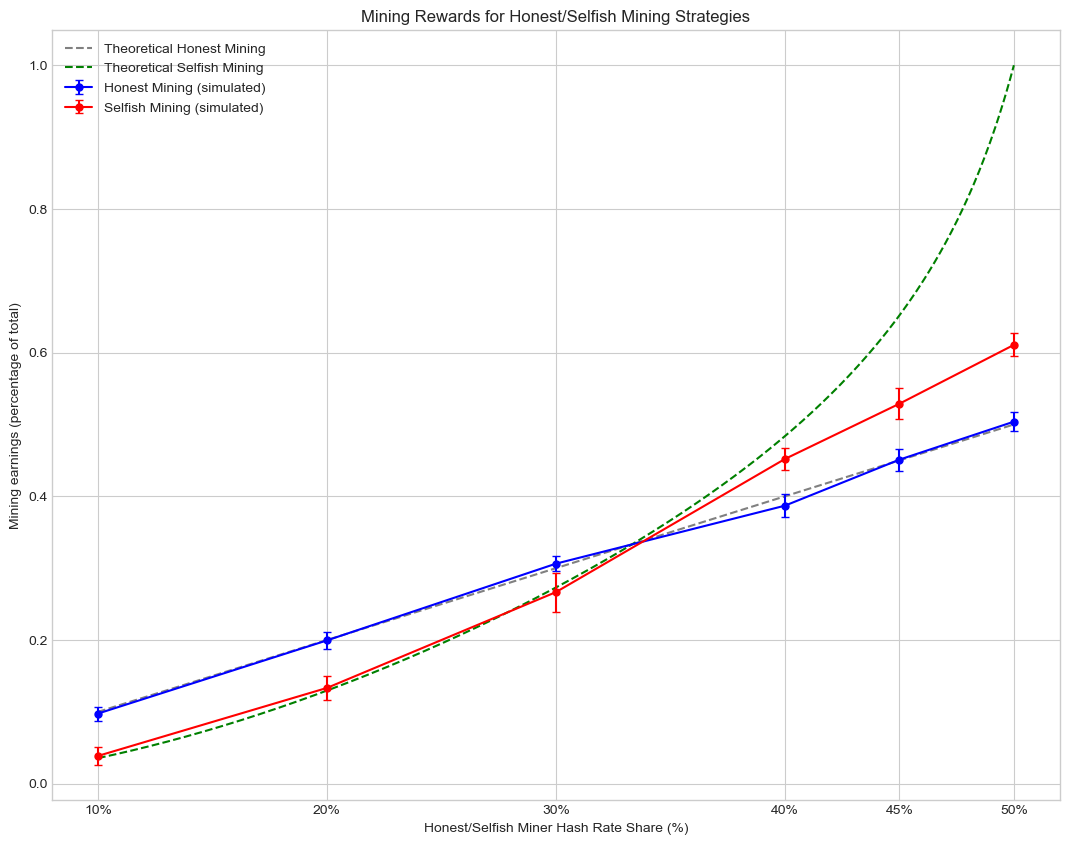

In [97]:
labels = ['10%', '20%', '30%', '40%', '45%', '50%']

ameans = list(ares['mean'])
hmeans = list(hres['mean'])

aci = ares[['cimin', 'cimax']].to_numpy()
hci = hres[['cimin', 'cimax']].to_numpy()

ay_r = np.c_[ameans-aci[:,0],aci[:,1]-ameans ].T
hy_r = np.c_[hmeans-hci[:,0],hci[:,1]-hmeans ].T

tx = np.linspace(0.1, 0.5, 500)
ty = ((tx*((1-tx)**2)*(4*tx)) - (tx**3))/(1-tx*(1+(2-tx)*tx))

plt.figure(figsize=plotSize)
#plt.bar(ares['id'], ares['mean'], yerr=y_r, align='center', capsize=5)
plt.plot(ares['id'], ares['id'], linestyle='dashed', color='grey', label="Theoretical Honest Mining")
plt.errorbar(x=hres['id'], y=hres['mean'], yerr=hy_r, capsize=3, linestyle='-', marker='.', markersize=10, color='blue', label="Honest Mining (simulated)")
plt.plot(tx, ty, linestyle='dashed', color='green', label="Theoretical Selfish Mining")
plt.errorbar(x=ares['id'], y=ares['mean'], yerr=ay_r, capsize=3, linestyle='-', marker='.', markersize=10, color='red', label="Selfish Mining (simulated)")
plt.xticks(ares['id'], labels)

plt.xlabel('Honest/Selfish Miner Hash Rate Share (%)')
plt.ylabel('Mining earnings (percentage of total)')
plt.title('Mining Rewards for Honest/Selfish Mining Strategies')
plt.legend()
plt.savefig('figures/selfish-mining-rewards-full.eps', format='eps')
plt.show()

In [95]:
ares

,id,mean,var,cimin,cimax
0,0.10,0.038721,0.000760,0.025822,0.051620
1,0.20,0.133337,0.001353,0.116121,0.150552
2,0.30,0.266686,0.003347,0.239610,0.293763
3,0.40,0.451947,0.000990,0.437225,0.466670
4,0.45,0.528860,0.002170,0.507061,0.550660
5,0.50,0.610757,0.001160,0.594814,0.626701


In [213]:
df = results.get_scalars('run =~ SelfishMining-** AND module =~ BitcoinNetwork.miner[0].blockchainManager AND name =~ attackResult:sum', include_attrs=True, include_fields=True, include_itervars=True).sort_values(['H', 'module', 'name'])

In [218]:
df[["module", "name", "value", "source", "title", "unit", "H"]]

,module,name,value,source,title,unit,H
1,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,11.0,attackResult,"Attack Result, sum",successes,20
17,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,12.0,attackResult,"Attack Result, sum",successes,20
19,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,9.0,attackResult,"Attack Result, sum",successes,20
22,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,10.0,attackResult,"Attack Result, sum",successes,20
27,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,11.0,attackResult,"Attack Result, sum",successes,20
30,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,12.0,attackResult,"Attack Result, sum",successes,20
36,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,8.0,attackResult,"Attack Result, sum",successes,20
38,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,8.0,attackResult,"Attack Result, sum",successes,20
40,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,10.0,attackResult,"Attack Result, sum",successes,20
42,BitcoinNetwork.miner[0].blockchainManager,attackResult:sum,9.0,attackResult,"Attack Result, sum",successes,20


In [219]:
df.groupby(['H'])['value'].mean()

H
20             9.80
34.2857143    14.55
53.3333333    15.30
65.4545455    17.05
8.8888889      3.35
80            16.00
Name: value, dtype: float64